In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import glob
import requests
from bs4 import BeautifulSoup

# ensure that all columns are shown and that colum content is not cut
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width',1000)
pd.set_option('display.max_rows', 500) # ensure that all rows are shown

# Formulas

In [47]:
def quarters(month):
    if month <= 3:
        return 'Q1'
    if month <= 6:
        return 'Q2'
    if month <= 9:
        return 'Q3'
    return 'Q4'

# Data Analysis - Corporate Financial Data

## Loading Data

In [49]:
## Load Data
agg_path = '../raw_data/SEC_data/Simple/Aggregated/'
df_path = '../raw_data/secfsdstools/df/'
datasets = '../raw_data/datasets'

balance_sheet = pd.read_csv('../raw_data/balance_sheet.csv', index_col=0)
income_statement = pd.read_csv('../raw_data/income_statement.csv', index_col=0)
cash_flow_statement = pd.read_csv('../raw_data/cash_flow.csv', index_col=0)
#cash_flow_statement_ext = pd.read_csv(df_path+'cash_flow_extended.csv', index_col=0)

sub = pd.read_csv(agg_path+'sub_all.csv', index_col=0)
#sub = sub[['adsh', 'sic', 'stprba',
#           'afs', 'nciks']]

sub = sub[['adsh', 'sic',
           'afs']]

In [52]:
#Clean up financial statements

balance_sheet.drop(['coreg', 'report', 'form', 'fye', 'qtrs'], axis=1, inplace=True)
income_statement.drop(['coreg', 'report', 'form', 'fye', 'qtrs'], axis=1, inplace=True)
cash_flow_statement.drop(['coreg', 'report', 'form', 'fye', 'qtrs'], axis=1, inplace=True)

balance_sheet.drop_duplicates(inplace=True)
income_statement.drop_duplicates(inplace=True)
cash_flow_statement.drop_duplicates(inplace=True)

balance_sheet['date'] = pd.to_datetime(balance_sheet['date'])
income_statement['date'] = pd.to_datetime(income_statement['date'])
cash_flow_statement['date'] = pd.to_datetime(cash_flow_statement['date'])

# Remove 2009 and earlier

balance_sheet = balance_sheet[(balance_sheet.date.dt.year>=2010)&(balance_sheet.date.dt.year<2025)]
income_statement = income_statement[(income_statement.date.dt.year>=2010)&(income_statement.date.dt.year<2025)]
cash_flow_statement = cash_flow_statement[(cash_flow_statement.date.dt.year>=2010)&(cash_flow_statement.date.dt.year<2025)]


In [53]:
print(f'{balance_sheet.shape = }, {income_statement.shape = }, {cash_flow_statement.shape = }')

balance_sheet.shape = (283381, 23), income_statement.shape = (315436, 20), cash_flow_statement.shape = (334437, 19)


## Merging & Cleaning Data

Revenues
CostOfRevenue
GrossProfit
OperatingExpenses
OperatingIncomeLoss
IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit
AllIncomeTaxExpenseBenefit
IncomeLossFromContinuingOperations
IncomeLossFromDiscontinuedOperationsNetOfTax
ProfitLoss
NetIncomeLossAttributableToNoncontrollingInterest


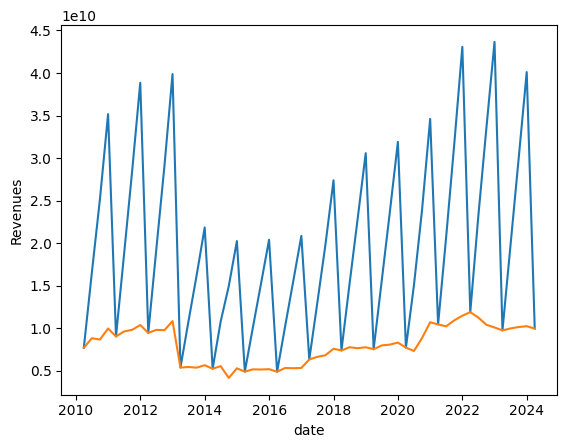

In [54]:
# Difference quarterly data for income statements

income_statement_adj = income_statement.sort_values(['cik', 'date']).reset_index(drop=True)
for col in income_statement_adj.columns[8:-1]:
    print(col)
    income_statement_adj[col] = (income_statement_adj.groupby(['cik','fy'])[col].diff().fillna(income_statement_adj[col])    )

# Visualize 
test = income_statement[income_statement.cik==1800]
test_adj = income_statement_adj[income_statement_adj.cik==1800]

sns.lineplot(x=test.date, y=test.Revenues);
sns.lineplot(x=test_adj.date, y=test_adj.Revenues);

In [55]:
df_financials = balance_sheet.merge(income_statement_adj, how='inner', on=['adsh', 'cik', 'name', 'fy', 'fp', 'date', 'filed', 'ddate'], 
                                   suffixes=('_bs', '_is'))
df_financials = df_financials.merge(cash_flow_statement, how='inner', on=['adsh', 'cik', 'name', 'fy', 'fp', 'date', 'filed', 'ddate'], 
                                   suffixes=('', '_cf'))
df_financials = df_financials.merge(sub, how='left', on='adsh')
df_financials.shape  #273309 observations


(273309, 48)

In [56]:
# Create 2-digit SIC Code

df_financials['sic_2d'] = df_financials.sic.apply(lambda x: str(x)[:2])
df_financials.sic_2d.nunique() #70

70

In [57]:
df_financials['quarter'] = df_financials.apply(lambda x: str(x.date.year)+'-'+quarters(x.date.month), axis=1)
df_financials['year'] = df_financials.date.dt.year
#df_financials['n_year'] = df_financials.groupby(['cik', 'year'])['year'].transform('count')
#df_financials = df_financials[df_financials.n_year==4]

In [59]:

drop_cols = ['adsh', 'name', 'fy', 'fp', 'filed', 'ddate', 'sic']

df_financials.drop(columns=drop_cols, inplace=True)


df_financials = df_financials.sort_values(['cik', 'date']).drop_duplicates().reset_index(drop=True)
df_financials.to_csv(datasets+'/df_financials.csv')

df_financials.shape

#273306 observations

(273306, 44)

In [60]:
df_financials.cik.nunique() #12,175

12175

## Save Sample & CIK

In [61]:
# Save sample of company data

abbot = df_financials[df_financials.cik==1800]
abbot.to_csv('../raw_data/secfsdstools/df/abbot_sample.csv')


In [62]:
# Save list of unique CIK identifiers

final_cik_list = df_financials[['cik']].drop_duplicates()
final_cik_list.reset_index(drop=True, inplace=True)
final_cik_list.to_csv(df_path+'final_cik_list.csv')


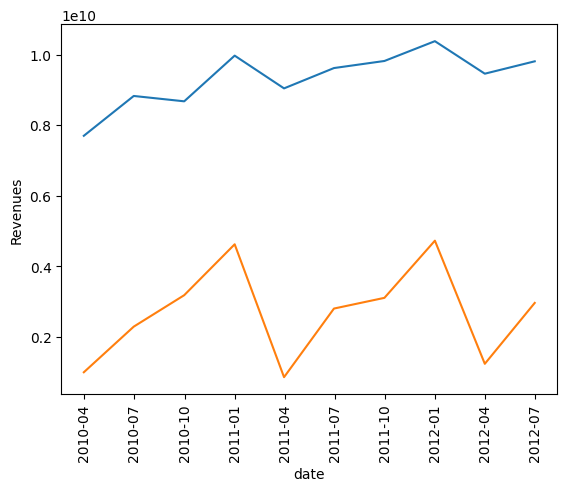

In [63]:
# Ensure differencing works for IS variables

abbot = df_financials[df_financials.cik==1800].iloc[:10]
sns.lineplot(x='date', y='Revenues', data=abbot);
sns.lineplot(x='date', y='NetIncomeLoss', data=abbot);
plt.xticks(rotation=90);


# Fred Data

In [64]:
fred = pd.read_csv('../raw_data/Datasets/processed_FRED_data_2.csv')
fred['date'] = pd.to_datetime(fred.Date) + pd.tseries.offsets.MonthEnd(0)
fred.drop(['Date'], axis=1, inplace=True)
fred = fred[fred.date.dt.year>=2010]

In [65]:
# Merge monthly data onto the quarter - shows only the condition of the economy during the reporting month 
# (i.e. the last month of the reporting quarter)

df_fin_fred = df_financials.merge(fred, how='left', on='date')
df_fin_fred.reset_index(drop=True, inplace=True)
df_fin_fred.to_csv(datasets+'/df_financials_fred.csv')

In [66]:
df_fin_fred.cik.nunique() # 12,175 companies

12175

In [67]:
df_fin_fred.head(3)

,cik,date,Assets,AssetsCurrent,Cash,AssetsNoncurrent,Liabilities,LiabilitiesCurrent,LiabilitiesNoncurrent,Equity,HolderEquity,RetainedEarnings,AdditionalPaidInCapital,TreasuryStockValue,TemporaryEquity,RedeemableEquity,LiabilitiesAndEquity,Revenues,CostOfRevenue,GrossProfit,OperatingExpenses,OperatingIncomeLoss,IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit,AllIncomeTaxExpenseBenefit,IncomeLossFromContinuingOperations,IncomeLossFromDiscontinuedOperationsNetOfTax,ProfitLoss,NetIncomeLossAttributableToNoncontrollingInterest,NetIncomeLoss,NetCashProvidedByUsedInOperatingActivitiesContinuingOperations,NetCashProvidedByUsedInFinancingActivitiesContinuingOperations,NetCashProvidedByUsedInInvestingActivitiesContinuingOperations,NetCashProvidedByUsedInOperatingActivities,NetCashProvidedByUsedInFinancingActivities,NetCashProvidedByUsedInInvestingActivities,CashProvidedByUsedInOperatingActivitiesDiscontinuedOperations,CashProvidedByUsedInInvestingActivitiesDiscontinuedOperations,CashProvidedByUsedInFinancingActivitiesDiscontinuedOperations,EffectOfExchangeRateFinal,CashPeriodIncreaseDecreaseIncludingExRateEffectFinal,afs,sic_2d,quarter,year,GDP,interest_rate,unemployment_rate,median_cpi
0,1750,2010-08-31,1.532733e+09,872263000.0,52155000.0,409978000.0,773074000.0,349233000.0,423841000.0,759659000.0,759659000.0,432961000.0,0.0,-108049000.0,0.0,0.0,1.532733e+09,412197000.0,341309000.0,70888000.0,419413000.0,-348525000.0,21065000.0,7391000.0,13674000.0,0.0,13674000.0,0.0,13674000.0,7218000.0,4382000.0,-38828000.0,7218000.0,4382000.0,-38828000.0,0.0,0.0,0.0,13000.0,-27215000.0,1-LAF,37,2010-Q3,2010,2.807663,0.19,9.6,0.430206
1,1750,2010-11-30,1.557227e+09,881764000.0,49320000.0,411711000.0,776335000.0,351806000.0,424529000.0,780892000.0,780892000.0,449775000.0,0.0,-102477000.0,0.0,0.0,1.557227e+09,447054000.0,372878000.0,74176000.0,454496000.0,-380320000.0,28397000.0,11583000.0,16814000.0,0.0,16814000.0,0.0,30488000.0,29812000.0,1215000.0,-61079000.0,29812000.0,1215000.0,-61079000.0,0.0,0.0,0.0,2000.0,-30050000.0,1-LAF,37,2010-Q4,2010,1.255460,0.19,9.8,1.318299
2,1750,2011-02-28,1.655991e+09,927839000.0,54716000.0,409295000.0,851395000.0,419182000.0,432213000.0,804596000.0,804596000.0,467693000.0,0.0,-101281000.0,0.0,0.0,1.655991e+09,436695000.0,360307000.0,76388000.0,429974000.0,-353586000.0,30361000.0,10408000.0,19953000.0,-2035000.0,17918000.0,0.0,48406000.0,59902000.0,-1053000.0,-83527000.0,59902000.0,-1053000.0,-83527000.0,0.0,0.0,0.0,24000.0,-24654000.0,1-LAF,37,2011-Q1,2011,-1.361790,0.16,8.9,2.816969


# Market Cap and Stocks

In [68]:
## Unused - old data
#market_cap = pd.read_csv(datasets+'/marketcap_shares_outstanding.csv')
#stocks_yahoo = pd.read_csv(datasets+'/processed_yahoo_data.csv')
#stocks_kaggle = pd.read_csv(datasets+'/processed_data.csv')
#tickers = pd.read_csv(datasets+'/tickers_with_cik_list_with_sec_ciks.csv')

# Updated Market Cap and stocks
market_cap_ciq = pd.read_excel(datasets+'/market_cap_CIQ.xlsx')
stocks = pd.read_csv(datasets+'/processed_yahoo_data_update.csv')

## Market Cap - yahoo

In [21]:
market_cap.head()

,Ticker,Date,Monthly Avg Market Cap,Monthly Market Cap (End of Month),Shares Outstanding
0,FLIC,2010-01-31 00:00:00-05:00,1.474772e+08,1.439013e+08,22531300
1,FLIC,2010-02-28 00:00:00-05:00,1.416695e+08,1.492464e+08,22531300
2,FLIC,2010-03-31 00:00:00-04:00,1.500160e+08,1.442612e+08,22531300
3,FLIC,2010-04-30 00:00:00-04:00,1.477159e+08,1.540781e+08,22531300
4,FLIC,2010-05-31 00:00:00-04:00,1.546587e+08,1.517435e+08,22531300


0.0


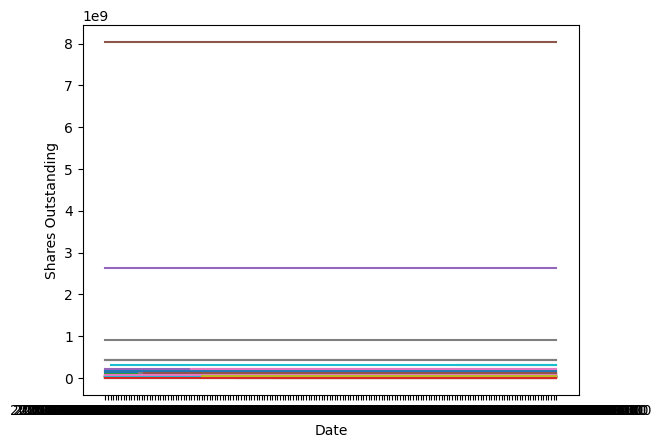

In [22]:
# Sense check on Shares

print(market_cap.groupby('Ticker')['Shares Outstanding'].std().max())

for t in market_cap.Ticker.unique()[200:250]:
    sns.lineplot(x = market_cap[market_cap.Ticker==t].Date, y = market_cap[market_cap.Ticker==t]['Shares Outstanding'])
    


In [23]:
market_cap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528075 entries, 0 to 528074
Data columns (total 5 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Ticker                             528075 non-null  object 
 1   Date                               528075 non-null  object 
 2   Monthly Avg Market Cap             528075 non-null  float64
 3   Monthly Market Cap (End of Month)  528075 non-null  float64
 4   Shares Outstanding                 528075 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 20.1+ MB


In [24]:
#Clean Market Cap

market_cap['date'] = market_cap.Date.apply(lambda x: pd.to_datetime(x[:7], format='%Y-%m') + pd.tseries.offsets.MonthEnd(0))
market_cap['quarter'] = market_cap['date'].apply(lambda x: str(x.year)+'-'+quarters(x.month))
market_cap.drop(['Shares Outstanding', 'Date', 'Monthly Market Cap (End of Month)'], axis=1, inplace=True)
market_cap.head()


,Ticker,Monthly Avg Market Cap,date,quarter
0,FLIC,1.474772e+08,2010-01-31,2010-Q1
1,FLIC,1.416695e+08,2010-02-28,2010-Q1
2,FLIC,1.500160e+08,2010-03-31,2010-Q1
3,FLIC,1.477159e+08,2010-04-30,2010-Q2
4,FLIC,1.546587e+08,2010-05-31,2010-Q2


In [25]:
market_cap_qtr = market_cap.groupby(['Ticker', 'quarter'], as_index=False).agg({'Monthly Avg Market Cap': 'mean', 
                                                                           'date': 'last'})


market_cap_qtr.drop('quarter', axis=1, inplace=True)

market_cap_qtr.head()

,Ticker,Monthly Avg Market Cap,date
0,A,5.867042e+09,2010-03-31
1,A,6.236717e+09,2010-06-30
2,A,5.432837e+09,2010-09-30
3,A,6.832947e+09,2010-12-31
4,A,8.087156e+09,2011-03-31


In [26]:
tickers = tickers[tickers.Active==True]
tickers.drop('Active', inplace=True, axis=1)
tickers.drop_duplicates(inplace=True)

tickers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2781 entries, 2 to 9110
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cik     2781 non-null   int64 
 1   Ticker  2781 non-null   object
dtypes: int64(1), object(1)
memory usage: 65.2+ KB


## Market Cap - CIQ

In [69]:
market_cap_ciq.head(3)

,CIK,TICKER,2010-03-31 00:00:00,2010-06-01 00:00:00,2010-09-01 00:00:00,2010-12-01 00:00:00,2011-03-01 00:00:00,2011-06-01 00:00:00,2011-09-01 00:00:00,2011-12-01 00:00:00,2012-03-01 00:00:00,2012-06-01 00:00:00,2012-09-01 00:00:00,2012-12-01 00:00:00,2013-03-01 00:00:00,2013-06-01 00:00:00,2013-09-01 00:00:00,2013-12-01 00:00:00,2014-03-01 00:00:00,2014-06-01 00:00:00,2014-09-01 00:00:00,2014-12-01 00:00:00,2015-03-01 00:00:00,2015-06-01 00:00:00,2015-09-01 00:00:00,2015-12-01 00:00:00,2016-03-01 00:00:00,2016-06-01 00:00:00,2016-09-01 00:00:00,2016-12-01 00:00:00,2017-03-01 00:00:00,2017-06-01 00:00:00,2017-09-01 00:00:00,2017-12-01 00:00:00,2018-03-01 00:00:00,2018-06-01 00:00:00,2018-09-01 00:00:00,2018-12-01 00:00:00,2019-03-01 00:00:00,2019-06-01 00:00:00,2019-09-01 00:00:00,2019-12-01 00:00:00,2020-03-01 00:00:00,2020-06-01 00:00:00,2020-09-01 00:00:00,2020-12-01 00:00:00,2021-03-01 00:00:00,2021-06-01 00:00:00,2021-09-01 00:00:00,2021-12-01 00:00:00,2022-03-01 00:00:00,2022-06-01 00:00:00,2022-09-01 00:00:00,2022-12-01 00:00:00,2023-03-01 00:00:00,2023-06-01 00:00:00,2023-09-01 00:00:00,2023-12-01 00:00:00,2024-03-01 00:00:00,2024-06-01 00:00:00,Unnamed: 60,Unnamed: 61
0,1750,AIR,968.608169,717.675433,627.224054,999.106335,1045.889727,1024.472219,882.619592,727.886752,899.522315,465.726633,599.262240,613.481887,689.253332,798.292254,951.999128,1184.591980,1096.563364,961.515765,1104.985077,1020.415822,1169.855224,1047.944084,836.413175,867.829206,756.578079,847.552500,888.513077,1253.613643,1185.853500,1156.683042,1233.482121,1400.555148,1413.530350,1537.864588,1603.375292,1500.99564,1256.383853,1034.571501,1483.622182,1539.048342,1187.885731,694.139416,717.013293,1070.519072,1468.202552,1486.811809,1207.235825,1119.950163,1532.463485,1690.455035,1463.065298,1620.450147,1871.002647,1759.211398,2116.970540,2425.401340,2327.077505,2474.360425,NaN,0.0
1,1800,ABT,81793.253522,72454.943869,77618.323855,72668.808515,73510.135737,80698.372737,80848.585124,84931.014913,90127.495158,95221.651583,102854.132599,102743.402905,52774.747200,57163.579550,51798.986250,59048.843340,61383.336534,60092.560905,63516.245760,66736.657120,71480.279712,72859.767580,64938.534630,67813.586245,57942.529200,58046.005714,62186.063944,55358.856000,78779.520000,79995.947000,88922.346252,97438.826458,102666.969511,109416.448476,117258.700943,130056.46102,138040.998441,134307.119476,150794.364512,151114.539992,135837.262708,164520.303771,188649.971393,192283.507923,216498.602841,187969.803457,225856.930263,224112.690451,208390.699491,201498.438618,183597.877856,188183.917752,175237.118673,178798.509873,178481.568243,182077.819256,205827.560361,177773.173832,NaN,0.0
2,1961,WDDD,6.439651,5.736835,3.447379,7.469322,17.707102,25.700544,14.272381,11.014286,14.685715,11.372083,8.832039,13.601537,30.311997,34.959989,22.991222,13.939271,22.394357,13.300677,17.862549,14.527791,13.559272,9.772829,11.070730,4.583246,3.403401,2.062345,6.325700,11.348432,6.212089,7.403200,7.773360,8.266907,18.754773,11.104837,15.835353,13.63556,14.203708,18.175065,13.919634,14.317338,14.203708,13.578745,11.931115,16.192227,27.907446,6.567938,3.883650,2.284500,3.729447,1.770488,0.856688,0.716762,0.502590,0.336964,0.542569,0.319830,0.576265,1.484925,NaN,0.0


In [70]:
mkt_cap = market_cap_ciq.iloc[:, :-2].copy().sort_values(['CIK', 'TICKER'])
mkt_cap = market_cap_ciq.melt(id_vars=['CIK', 'TICKER'], value_vars=mkt_cap.columns[2:], var_name='date', value_name='market_cap')
mkt_cap = mkt_cap.sort_values(['CIK', 'date']).reset_index(drop=True)
mkt_cap['date'] = pd.to_datetime(mkt_cap.date)
mkt_cap.info() # 348,058 obs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348058 entries, 0 to 348057
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   CIK         348058 non-null  int64         
 1   TICKER      348058 non-null  object        
 2   date        348058 non-null  datetime64[ns]
 3   market_cap  252158 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 10.6+ MB


In [71]:
mkt_cap.head(3)

,CIK,TICKER,date,market_cap
0,1750,AIR,2010-03-31,968.608169
1,1750,AIR,2010-06-01,717.675433
2,1750,AIR,2010-09-01,627.224054


In [72]:
mkt_cap = mkt_cap.dropna().reset_index(drop=True)
mkt_cap.shape # 252,158 obs


(252158, 4)

In [73]:
# Save ticker list

cik_ticker = mkt_cap[['CIK', 'TICKER']].drop_duplicates().reset_index(drop=True)
cik_ticker.to_csv(datasets+'/cik_ticker_pairs.csv')

In [74]:
idx = mkt_cap.index
mkt_cap.sort_values(['CIK', 'TICKER', 'date'], inplace=True)


# One quarter ahead
mkt_cap['mc_qtr_growth'] = mkt_cap['market_cap'].diff()
mkt_cap['mc_qtr_growth_pct'] = mkt_cap['mc_qtr_growth'] / mkt_cap['market_cap'].shift(1)

mask = mkt_cap.TICKER != mkt_cap.TICKER.shift(1)
mkt_cap.loc[mkt_cap['mc_qtr_growth'][mask].index, 'mc_qtr_growth'] = np.nan
mkt_cap.loc[mkt_cap['mc_qtr_growth_pct'][mask].index, 'mc_qtr_growth_pct'] = np.nan


# One year ahead
mkt_cap['mc_yr_growth'] = mkt_cap['market_cap'].diff(4)
mkt_cap['mc_yr_growth_pct'] = mkt_cap['mc_yr_growth'] / mkt_cap['market_cap'].shift(4)

mask = mkt_cap.TICKER != mkt_cap.TICKER.shift(4)
mkt_cap.loc[mkt_cap['mc_yr_growth'][mask].index, 'mc_yr_growth'] = np.nan
mkt_cap.loc[mkt_cap['mc_yr_growth_pct'][mask].index, 'mc_yr_growth_pct'] = np.nan


# Two years ahead
mkt_cap['mc_2yr_growth'] = mkt_cap['market_cap'].diff(8)
mkt_cap['mc_2yr_growth_pct'] = mkt_cap['mc_2yr_growth'] / mkt_cap['market_cap'].shift(8)

mask = mkt_cap.TICKER != mkt_cap.TICKER.shift(8)
mkt_cap.loc[mkt_cap['mc_2yr_growth'][mask].index, 'mc_2yr_growth'] = np.nan
mkt_cap.loc[mkt_cap['mc_2yr_growth_pct'][mask].index, 'mc_2yr_growth_pct'] = np.nan


# Small Cap Flag 
mkt_cap['small_cap'] = mkt_cap.market_cap.apply(lambda x: 1 if x <= 2*10**3 else 0) # less than USD 2_000_000_000
mkt_cap['micro_cap'] = mkt_cap.market_cap.apply(lambda x: 1 if x < 3*10**2 else 0) # less than USD 300_000_000
mkt_cap['quarter'] = mkt_cap.date.apply(lambda x: str(x.year)+'-'+quarters(x.month))

mkt_cap.reindex(idx)
mkt_cap.iloc[1042:1052, :]


,CIK,TICKER,date,market_cap,mc_qtr_growth,mc_qtr_growth_pct,mc_yr_growth,mc_yr_growth_pct,mc_2yr_growth,mc_2yr_growth_pct,small_cap,micro_cap,quarter
1042,4457,UHAL,2010-03-31,1064.506811,NaN,NaN,NaN,NaN,NaN,NaN,1,0,2010-Q1
1043,4457,UHAL,2010-06-01,971.958051,-92.548759,-0.086941,NaN,NaN,NaN,NaN,1,0,2010-Q2
1044,4457,UHAL,2010-09-01,1609.995473,638.037422,0.656445,NaN,NaN,NaN,NaN,1,0,2010-Q3
1045,4457,UHAL,2010-12-01,1970.582694,360.587221,0.223968,NaN,NaN,NaN,NaN,1,0,2010-Q4
1046,4457,UHAL,2011-03-01,1809.602755,-160.979939,-0.081692,745.095944,0.699945,NaN,NaN,1,0,2011-Q1
1047,4457,UHAL,2011-06-01,1663.328656,-146.274098,-0.080832,691.370605,0.711317,NaN,NaN,1,0,2011-Q2
1048,4457,UHAL,2011-09-01,1388.035313,-275.293344,-0.165507,-221.960160,-0.137864,NaN,NaN,1,0,2011-Q3
1049,4457,UHAL,2011-12-01,1518.819258,130.783946,0.094222,-451.763436,-0.229254,NaN,NaN,1,0,2011-Q4
1050,4457,UHAL,2012-03-01,2008.425725,489.606466,0.322360,198.822970,0.109871,943.918914,0.886719,0,0,2012-Q1
1051,4457,UHAL,2012-06-01,1599.995501,-408.430224,-0.203358,-63.333155,-0.038076,628.037450,0.646157,1,0,2012-Q2


In [75]:
mkt_cap.drop(columns='date', inplace=True)
mkt_cap.to_csv(datasets+'/market_cap_data.csv')
mkt_cap.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252158 entries, 0 to 252157
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CIK                252158 non-null  int64  
 1   TICKER             252158 non-null  object 
 2   market_cap         252158 non-null  float64
 3   mc_qtr_growth      246235 non-null  float64
 4   mc_qtr_growth_pct  246235 non-null  float64
 5   mc_yr_growth       228520 non-null  float64
 6   mc_yr_growth_pct   228520 non-null  float64
 7   mc_2yr_growth      205071 non-null  float64
 8   mc_2yr_growth_pct  205071 non-null  float64
 9   small_cap          252158 non-null  int64  
 10  micro_cap          252158 non-null  int64  
 11  quarter            252158 non-null  object 
dtypes: float64(7), int64(3), object(2)
memory usage: 23.1+ MB


## Stocks

In [76]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612204 entries, 0 to 612203
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Ticker                612204 non-null  object 
 1   Month                 612204 non-null  object 
 2   Monthly_Avg_Close     612204 non-null  float64
 3   Monthly_Volume_Total  612204 non-null  float64
 4   Monthly_Volume_Avg    612204 non-null  float64
 5   Monthly_Volatility    611823 non-null  float64
dtypes: float64(4), object(2)
memory usage: 28.0+ MB


In [77]:
stocks.head(3)

,Ticker,Month,Monthly_Avg_Close,Monthly_Volume_Total,Monthly_Volume_Avg,Monthly_Volatility
0,AIR,2010-01,21.941817,6383700.0,335984.210526,0.232313
1,AIR,2010-02,20.758845,5145100.0,270794.736842,0.295710
2,AIR,2010-03,22.245808,6584700.0,286291.304348,0.255534


In [78]:
#stocks = pd.concat((stocks_kaggle, stocks_yahoo), axis=0).reset_index(drop=True)
#stocks.shape

In [79]:
stocks['date'] = pd.to_datetime(stocks.Month, format='%Y-%m') + pd.tseries.offsets.MonthEnd(0)
stocks['quarter'] = stocks.apply(lambda x: str(x.date.year)+'-'+quarters(x.date.month), axis=1)
stocks.drop(columns=['Month', 'Monthly_Volume_Avg'], inplace=True)
stocks.head()

,Ticker,Monthly_Avg_Close,Monthly_Volume_Total,Monthly_Volatility,date,quarter
0,AIR,21.941817,6383700.0,0.232313,2010-01-31,2010-Q1
1,AIR,20.758845,5145100.0,0.295710,2010-02-28,2010-Q1
2,AIR,22.245808,6584700.0,0.255534,2010-03-31,2010-Q1
3,AIR,22.615037,5569000.0,0.252328,2010-04-30,2010-Q2
4,AIR,20.316029,9641700.0,0.750293,2010-05-31,2010-Q2


In [80]:
# Define function to compute the weighted average:
#w_avg = lambda x: np.average(x, weights=stocks.loc[x.index, "Monthly_Volume_Total"])
# not working because of zero traded volume. we should consider removing stocks with very low liquity/traded volume


# Groupby and aggregate with weighted average function - apply simple average for now
stocks_qtr = stocks.groupby(['Ticker', 'quarter'], as_index=False).agg({'Monthly_Avg_Close': 'mean', 
                                                                           'Monthly_Volume_Total': 'mean', 
                                                                           'Monthly_Volatility': 'mean', 
                                                                           'date': 'last'})
stocks_qtr.drop('date', axis=1, inplace=True)

stocks_qtr.head()

,Ticker,quarter,Monthly_Avg_Close,Monthly_Volume_Total,Monthly_Volatility
0,A,2010-Q1,20.069606,1.027930e+08,0.159432
1,A,2010-Q2,21.334166,1.109090e+08,0.315123
2,A,2010-Q3,18.584304,1.054413e+08,0.292730
3,A,2010-Q4,23.373712,9.476348e+07,0.186036
4,A,2011-Q1,27.664029,1.139266e+08,0.305167


In [81]:
stocks_qtr.Ticker.nunique()

4313

## Merge stocks & market cap


In [82]:
stocks_marketcap = mkt_cap.merge(stocks_qtr, left_on=['TICKER', 'quarter'], right_on=['Ticker', 'quarter'], how='inner')
stocks_marketcap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190956 entries, 0 to 190955
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   CIK                   190956 non-null  int64  
 1   TICKER                190956 non-null  object 
 2   market_cap            190956 non-null  float64
 3   mc_qtr_growth         186984 non-null  float64
 4   mc_qtr_growth_pct     186984 non-null  float64
 5   mc_yr_growth          174960 non-null  float64
 6   mc_yr_growth_pct      174960 non-null  float64
 7   mc_2yr_growth         158829 non-null  float64
 8   mc_2yr_growth_pct     158829 non-null  float64
 9   small_cap             190956 non-null  int64  
 10  micro_cap             190956 non-null  int64  
 11  quarter               190956 non-null  object 
 12  Ticker                190956 non-null  object 
 13  Monthly_Avg_Close     190956 non-null  float64
 14  Monthly_Volume_Total  190956 non-null  float64
 15  

In [83]:
stocks_marketcap.CIK.nunique()

4259

# Merge all sets

In [29]:
df_fin_fred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230860 entries, 0 to 230859
Data columns (total 48 columns):
 #   Column                                                           Non-Null Count   Dtype         
---  ------                                                           --------------   -----         
 0   cik                                                              230860 non-null  int64         
 1   date                                                             230860 non-null  datetime64[ns]
 2   Assets                                                           230860 non-null  float64       
 3   AssetsCurrent                                                    230860 non-null  float64       
 4   Cash                                                             230860 non-null  float64       
 5   AssetsNoncurrent                                                 230860 non-null  float64       
 6   Liabilities                                                      230

In [45]:
stocks_marketcap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190956 entries, 0 to 190955
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   CIK                   190956 non-null  int64  
 1   TICKER                190956 non-null  object 
 2   market_cap            190956 non-null  float64
 3   mc_qtr_growth         186984 non-null  float64
 4   mc_qtr_growth_pct     186984 non-null  float64
 5   mc_yr_growth          174960 non-null  float64
 6   mc_yr_growth_pct      174960 non-null  float64
 7   mc_2yr_growth         158829 non-null  float64
 8   mc_2yr_growth_pct     158829 non-null  float64
 9   small_cap             190956 non-null  int64  
 10  micro_cap             190956 non-null  int64  
 11  quarter               190956 non-null  object 
 12  Ticker                190956 non-null  object 
 13  Monthly_Avg_Close     190956 non-null  float64
 14  Monthly_Volume_Total  190956 non-null  float64
 15  

In [84]:
#stocks_marketcap.drop(columns=['date'], inplace=True)
#merged_df = df_fin_fred.merge(stocks_marketcap, left_on=['cik', 'quarter'], right_on=['CIK', 'quarter'], how='inner')
merged_df = df_fin_fred.merge(mkt_cap, left_on=['cik', 'quarter'], right_on=['CIK', 'quarter'], how='inner')
#merged_df.info()


#merged_df = df_fin_fred.merge(mkt_cap, left_on=['cik', 'quarter'], right_on=['CIK', 'quarter'], how='inner')
#merged_df.info()

In [85]:
merged_df.cik.nunique()

5867

In [86]:
merged_df['n_year'] = merged_df.groupby(['cik', 'year'])['year'].transform('count')
merged_df = merged_df[merged_df.n_year==4]
merged_df.drop('n_year', axis=1, inplace=True)
merged_df.shape



(172784, 59)

In [87]:
merged_df['n_cik'] = merged_df.groupby(['cik'])['cik'].transform('count')
merged_df = merged_df[merged_df.n_cik>=12]
merged_df.drop('n_cik', axis=1, inplace=True)
merged_df.shape

(170124, 59)

In [88]:
merged_df = merged_df.drop_duplicates().reset_index(drop=True)
merged_df.shape

(170124, 59)

In [89]:
merged_df.to_csv(datasets+'/data_for_preprocessing.csv')
#merged_df.to_csv(datasets+'/merged_data_prelim_stocks.csv')

In [90]:
mkt_cap[mkt_cap.CIK==1750]

,CIK,TICKER,market_cap,mc_qtr_growth,mc_qtr_growth_pct,mc_yr_growth,mc_yr_growth_pct,mc_2yr_growth,mc_2yr_growth_pct,small_cap,micro_cap,quarter
0,1750,AIR,968.608169,NaN,NaN,NaN,NaN,NaN,NaN,1,0,2010-Q1
1,1750,AIR,717.675433,-250.932737,-0.259065,NaN,NaN,NaN,NaN,1,0,2010-Q2
2,1750,AIR,627.224054,-90.451379,-0.126034,NaN,NaN,NaN,NaN,1,0,2010-Q3
3,1750,AIR,999.106335,371.882281,0.592902,NaN,NaN,NaN,NaN,1,0,2010-Q4
4,1750,AIR,1045.889727,46.783392,0.046825,77.281557,0.079786,NaN,NaN,1,0,2011-Q1
5,1750,AIR,1024.472219,-21.417508,-0.020478,306.796787,0.427487,NaN,NaN,1,0,2011-Q2
6,1750,AIR,882.619592,-141.852627,-0.138464,255.395538,0.407184,NaN,NaN,1,0,2011-Q3
7,1750,AIR,727.886752,-154.732840,-0.175311,-271.219583,-0.271462,NaN,NaN,1,0,2011-Q4
8,1750,AIR,899.522315,171.635564,0.235800,-146.367411,-0.139945,-69.085854,-0.071325,1,0,2012-Q1
9,1750,AIR,465.726633,-433.795682,-0.482251,-558.745586,-0.545398,-251.948800,-0.351062,1,0,2012-Q2


In [91]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170124 entries, 0 to 170123
Data columns (total 59 columns):
 #   Column                                                           Non-Null Count   Dtype         
---  ------                                                           --------------   -----         
 0   cik                                                              170124 non-null  int64         
 1   date                                                             170124 non-null  datetime64[ns]
 2   Assets                                                           170124 non-null  float64       
 3   AssetsCurrent                                                    170124 non-null  float64       
 4   Cash                                                             170124 non-null  float64       
 5   AssetsNoncurrent                                                 170124 non-null  float64       
 6   Liabilities                                                      170